In [3]:
# code modified from:
# https://github.com/sweat0198/audio_classification_CNN_ESC-50/blob/master/esc-50-keras.ipynb

The original codes are available on https://github.com/shibuiwilliam/audio_classification_keras

# ESC-50 audio classification

This notebook is an example of audio classification using convolutional neural network.
<br>
The data used is [ESC-50](https://github.com/karoldvl/ESC-50), which consists of 50 classes of environmental audio dataset.<br>
One data is in .wav format with 5 seconds each, total of 2,000 files.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
# import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
# import seaborn as sn
from sklearn import model_selection
# from sklearn import preprocessing
import IPython.display as ipd
from tqdm import tqdm

In [6]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

## Preparation

In [7]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

In [8]:
# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [9]:
# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

In [10]:
# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

In [11]:
# This values are necessary to create and reshape data arrays
freq = 128
time = 1723

### Data is available on https://www.kaggle.com/mmoreaux/environmental-sound-classification-50


In [12]:
print(os.listdir())

['.config', 'drive', 'sample_data']


In [13]:
# define directories
base_dir = "./drive/MyDrive/HDA_project/data"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(base_dir, "esc50.csv")
audio_dir = os.path.join(base_dir, "audio/audio/44100/")

In [14]:
# load metadata
meta_data = pd.read_csv(meta_file)
meta_data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [15]:
# get data size
data_size = meta_data.shape
print(data_size)

(2000, 7)


In [16]:
# arrange target label and its name
class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i,"target"] not in class_dict.keys():
        class_dict[meta_data.loc[i,"target"]] = meta_data.loc[i,"category"]
class_pd = pd.DataFrame(list(class_dict.items()), columns=["labels","classes"])
class_pd

,labels,classes
0,0,dog
1,14,chirping_birds
2,36,vacuum_cleaner
3,19,thunderstorm
4,30,door_wood_knock
5,34,can_opening
6,9,crow
7,22,clapping
8,48,fireworks
9,41,chainsaw


## Hint:
It strongly recommended to use kaggle notebook to access data quickly and not mess with library issues.
The trained model with %20 validation data and %10 test data are available on
https://www.kaggle.com/tubistaj/model-files and
https://www.kaggle.com/tubistaj/test-array.

If you prefer use them you can continue with section ***Evaluate model***.
Otherwise, of course you are free to go ahead

## Load dataset

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


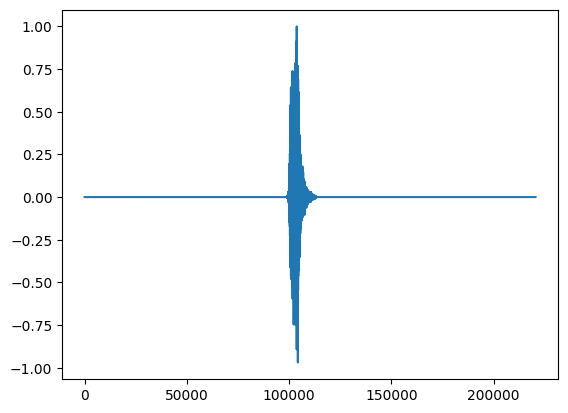

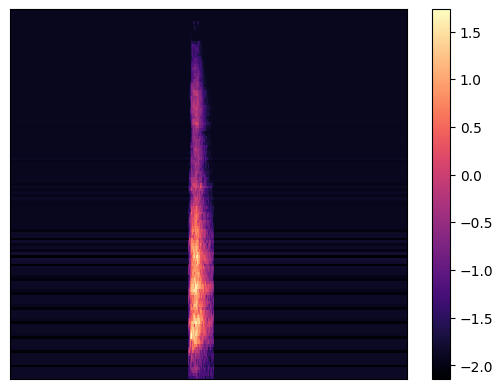

In [17]:
# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [18]:
ipd.Audio(x, rate=fs)

## Augment audio data

The augmented data available on https://www.kaggle.com/tubistaj/esc50aug, with using it you can pass this sections up to *Audio Classification with Deep Learning* section

The number of end of file names indicates the rate of splitting data in train and test. ie. esc_melsp_train_raw3.npz means %30 test rate.

However, if you do not want to use link you can go ahead.

In [19]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


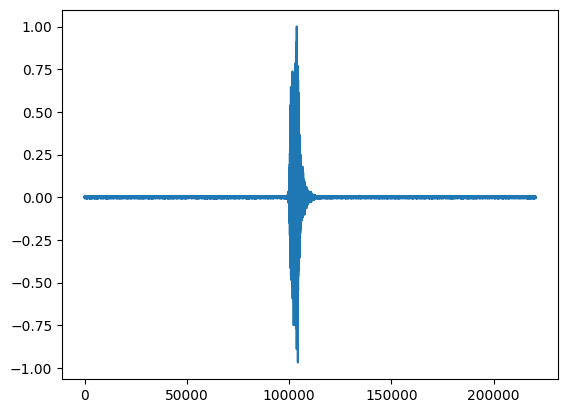

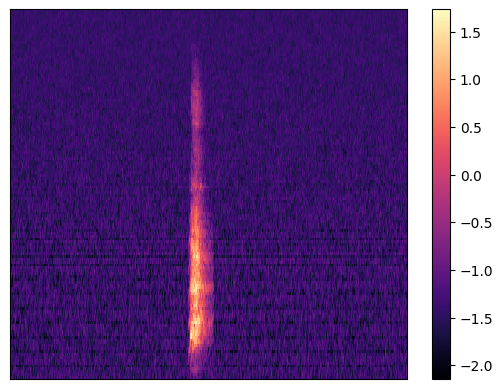

In [20]:
x_wn = add_white_noise(x)
melsp = calculate_melsp(x_wn)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_wn.shape, melsp.shape, fs))
show_wave(x_wn)
show_melsp(melsp, fs)

In [21]:
ipd.Audio(x_wn, rate=fs)

In [22]:
# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


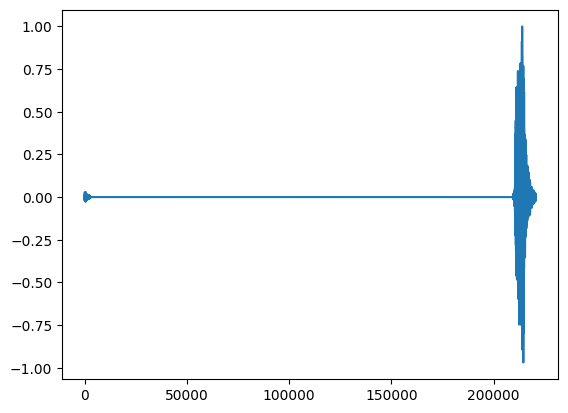

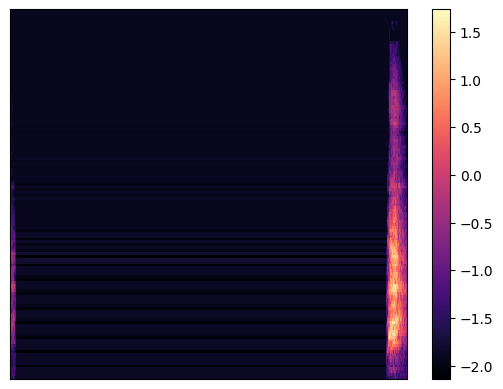

In [23]:
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)

In [24]:
ipd.Audio(x_ss, rate=fs)

In [25]:
# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate = rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


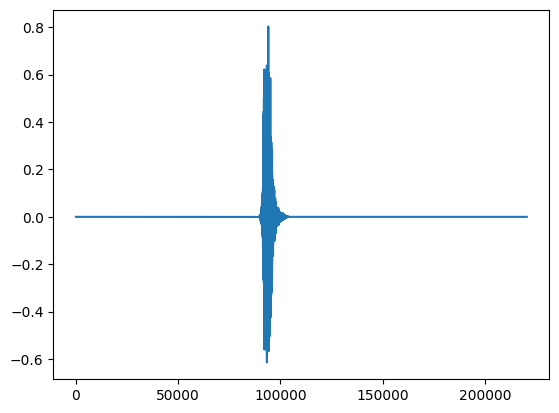

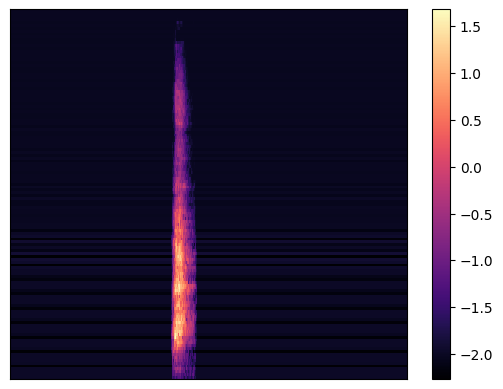

In [26]:
x_st = stretch_sound(x)
melsp = calculate_melsp(x_st)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x_st)
show_melsp(melsp, fs)

In [27]:
ipd.Audio(x_st, rate=fs)

## Split training dataset and test dataset

In [28]:
# get training dataset and target dataset
x = list(meta_data.loc[:, "filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train),
                                                                len(x_test),
                                                                len(y_test)))

x train:1500
y train:1500
x test:500
y test:500


In [29]:
a = np.zeros(50)
for c in y_test:
    a[c] += 1
print(a)

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


## Transform wav data to mel-stft array

Transform wav data files to mel-stft array, and save them as npz, separately with test, training and augmented training datasets.


In [30]:
# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

In [31]:
hfolder = './drive/MyDrive/HDA_project/' # home folder

In [32]:
# save test dataset
if not os.path.exists(hfolder + "esc_melsp_test.npz"):
    save_np_data(hfolder + "esc_melsp_test.npz", x_test,  y_test)

In [33]:
# save raw training dataset
if not os.path.exists(hfolder + "esc_melsp_train_raw.npz"):
    save_np_data(hfolder + "esc_melsp_train_raw.npz", x_train,  y_train)

In [34]:
# save training dataset with white noise
if not os.path.exists(hfolder + "esc_melsp_train_wn.npz"):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data(hfolder + "esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

In [35]:
# save training dataset with sound shift
if not os.path.exists(hfolder + "esc_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data(hfolder + "esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

In [36]:
# save training dataset with stretch
if not os.path.exists(hfolder + "esc_melsp_train_st.npz"):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data(hfolder + "esc_melsp_train_st.npz", x_train,  y_train, aug=stretch_sound, rates=rates)

In [37]:
os.listdir(hfolder)

['data',
 'esc_melsp_test.npz',
 'esc_melsp_train_raw.npz',
 'esc_melsp_train_wn.npz',
 'esc_melsp_train_ss.npz',
 'esc_melsp_train_st.npz',
 'esc_melsp_train_com.npz',
 'models',
 'models4',
 'model4.ipynb',
 'models4_esc10',
 'models3_esc10',
 'model4_esc10.ipynb',
 'model_evaluation_metrics.ipynb',
 'model3.ipynb']

In [38]:
# save training dataset with combination of white noise and shift or stretch
if not os.path.exists(hfolder + "esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez(hfolder + "esc_melsp_train_com.npz", x=np_data, y=np_targets)

# Audio classification with deep learning


## Preparation for deep learning

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
##
import numpy as np
from tqdm import tqdm
freq = 128
time = 1723

In [41]:
# dataset files are available on https://www.kaggle.com/tubistaj/esc50aug
files_dir = './drive/MyDrive/HDA_project/'
train_files = [
               files_dir + "esc_melsp_train_raw.npz",
              #  files_dir + "esc_melsp_train_ss.npz",
              #  files_dir + "esc_melsp_train_st.npz",
              #  files_dir + "esc_melsp_train_wn.npz",
              #  files_dir + "esc_melsp_train_com.npz"
               ]
test_file = files_dir + "esc_melsp_test.npz"

In [42]:
train_num = 1500 ##
test_num = 500 ##

In [43]:
##

import psutil

def print_memory():

    # Get memory usage
    memory = psutil.virtual_memory()

    # Print memory usage statistics
    # print("Total Memory:", memory.total)
    # print("Available Memory:", memory.available)
    # print("Used Memory:", memory.used)
    # print("Free Memory:", memory.free)
    print("Memory Usage Percentage:", memory.percent)

In [44]:
print_memory()

# define dataset placeholders
# the original dtype was float64, but since it exceeded memory it converted to float32
x_train = np.zeros(freq*time*train_num*len(train_files), dtype='float32').reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files), dtype='float32')

# load dataset
n = len(train_files) ##
for i in tqdm(range(n)):
    print_memory()
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

Memory Usage Percentage: 14.0


  0%|          | 0/1 [00:00<?, ?it/s]

Memory Usage Percentage: 14.0


100%|██████████| 1/1 [00:27<00:00, 27.56s/it]


In [45]:
# load test dataset
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

In [46]:
##
import os
import keras
from sklearn import model_selection
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [47]:
# redefine target data into one hot vector
classes = 50
y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

In [48]:
# reshape training dataset
x_train = x_train.reshape(train_num*len(train_files), freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

In [49]:
x_test, x_val, y_test, y_val= model_selection.train_test_split(x_test, y_test, test_size=3/5, random_state=1)

In [50]:

print("x train:{0}\ny train:{1}\nx val:{2}\ny val:{3}\nx test:{4}\ny test:{5}".format(x_train.shape,
                                                                                      y_train.shape,
                                                                                      x_val.shape,
                                                                                      y_val.shape,
                                                                                      x_test.shape,
                                                                                      y_test.shape))

x train:(1500, 128, 1723, 1)
y train:(1500, 50)
x val:(300, 128, 1723, 1)
y val:(300, 50)
x test:(200, 128, 1723, 1)
y test:(200, 50)


## Define convolutional neural network

In [51]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [52]:
# define CNN
inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 1723, 1)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 862, 32)         288       ['input_1[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 862, 32)         544       ['input_1[0][0]']             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 128, 862, 32)         1056      ['input_1[0][0]']             
                                                                                              

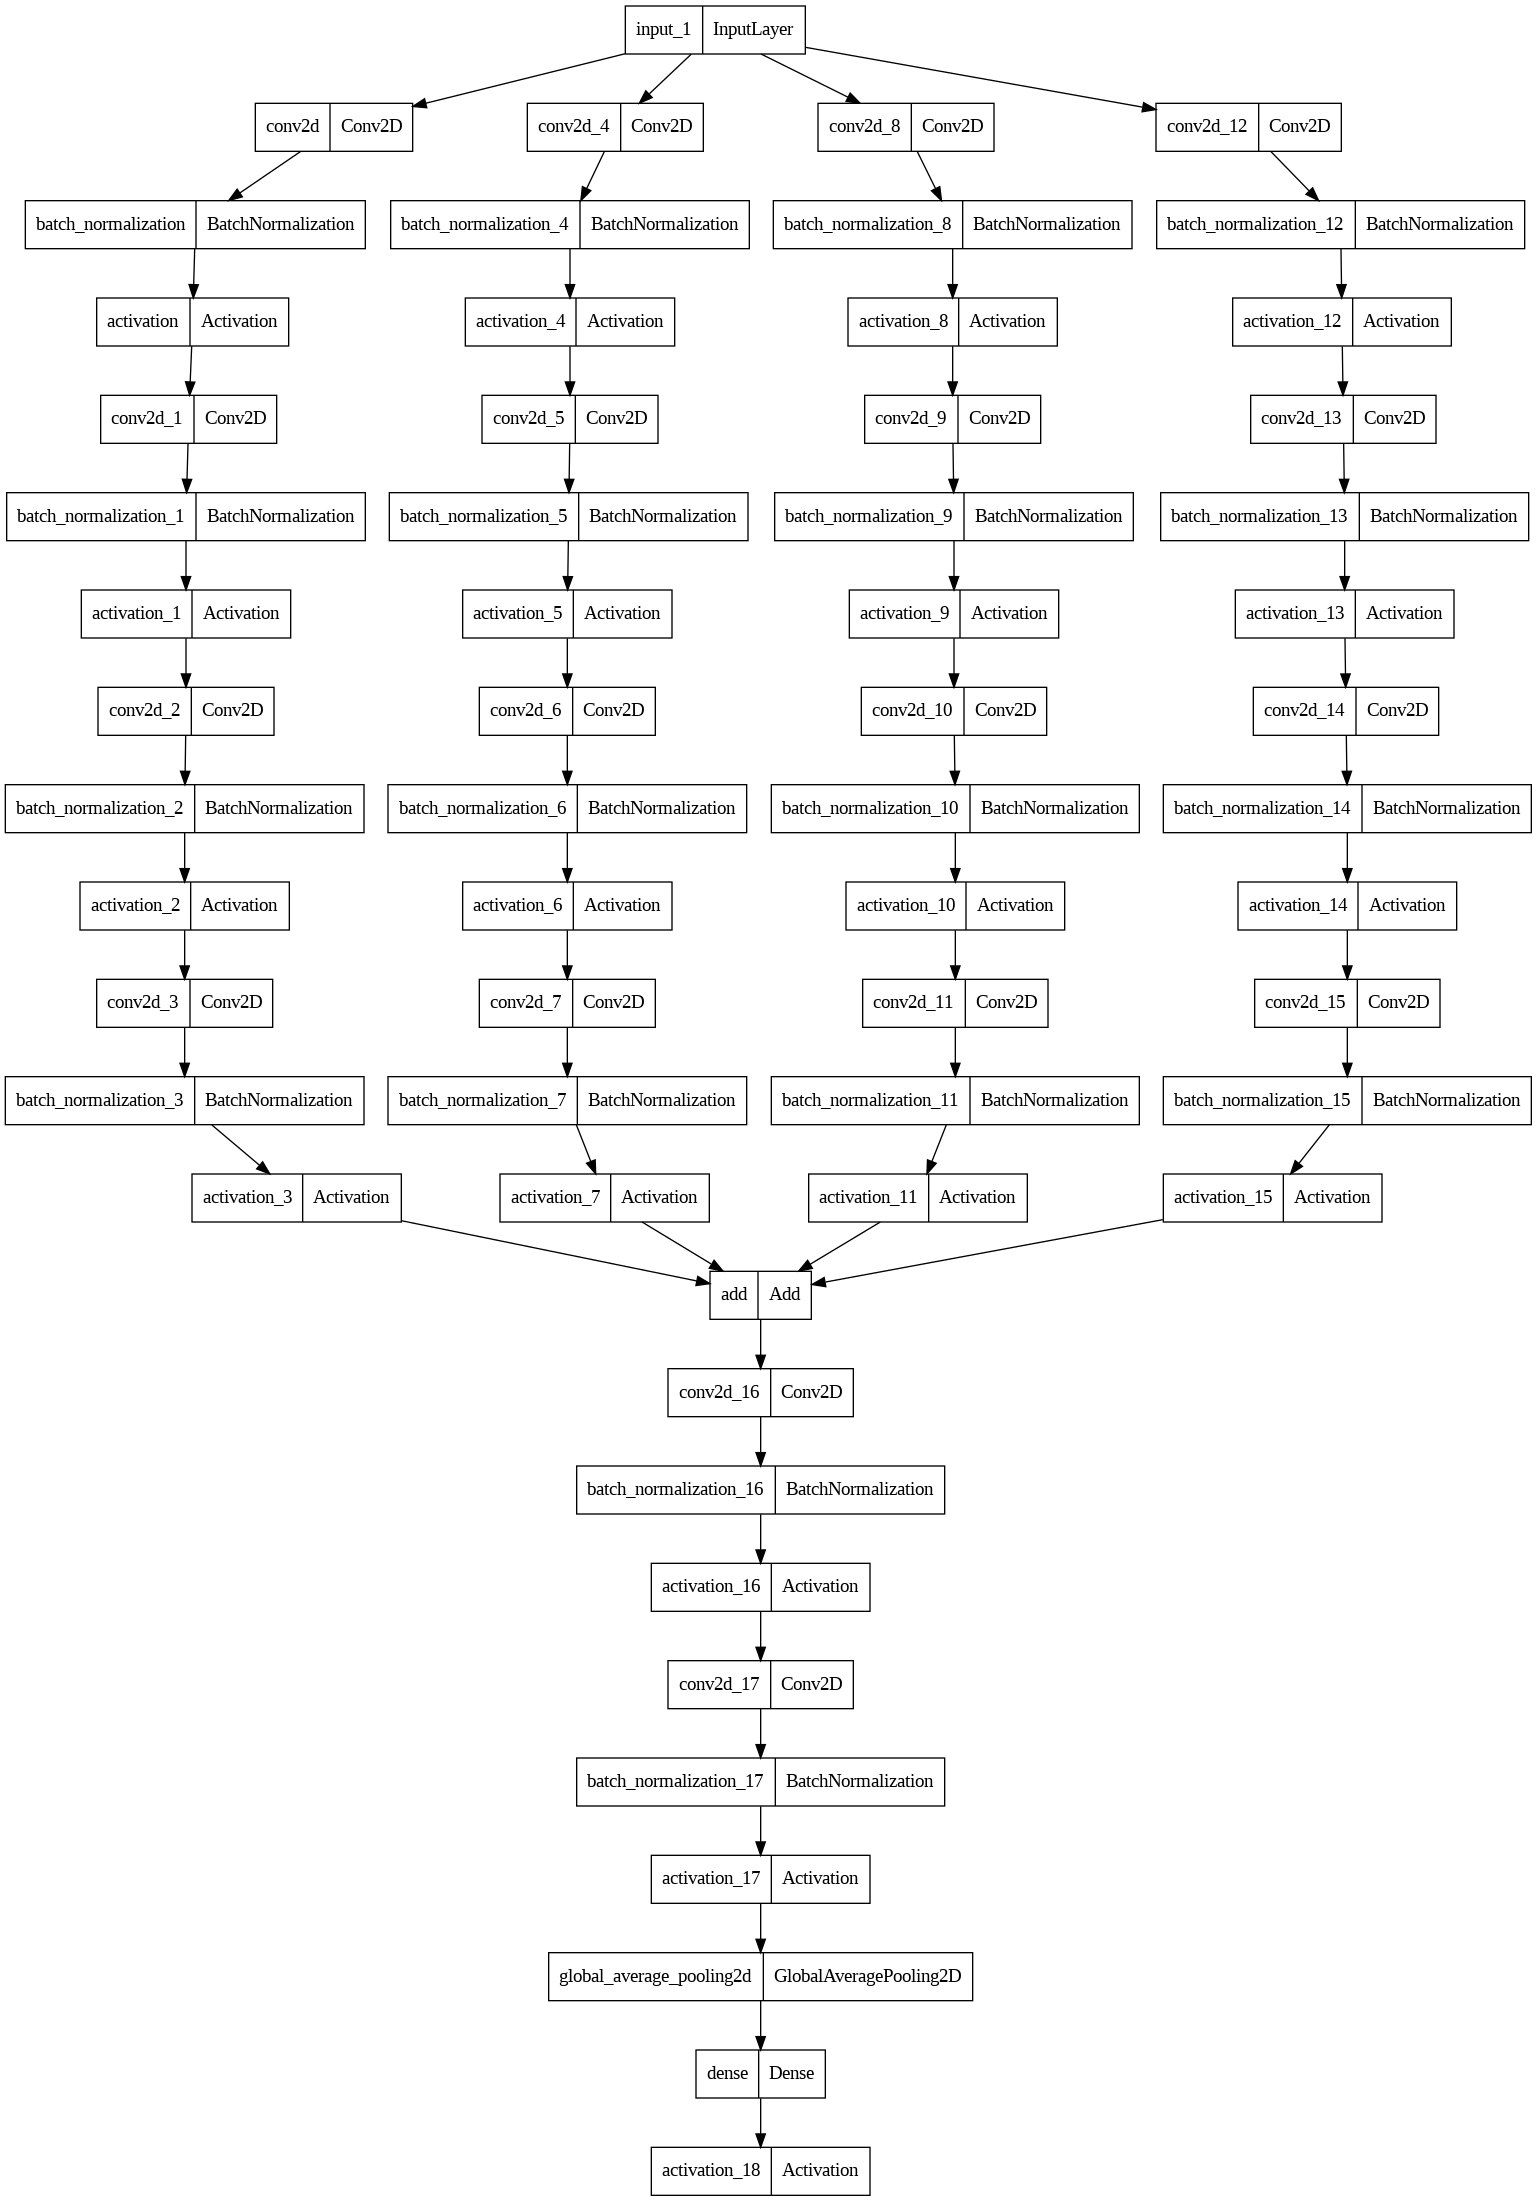

In [53]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')

## Optimization and callbacks

In [54]:
# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=0.00005, amsgrad=True)

# Let's train the model using Adam with amsgrad
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [55]:
# directory for model checkpoints
model_dir = "./drive/MyDrive/HDA_project/models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## Train CNN model with between class dataset

In [56]:
import tensorflow as tf

batch_size = 16
epochs = 20

model = tf.keras.models.load_model(model_dir + '/model_5.hdf5')

chkpt = os.path.join(model_dir, 'model_5_1.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, verbose=1, save_best_only = True)

model.fit(x_train,
          y_train,
          validation_data = (x_val, y_val),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [cp_cb],
          shuffle = True)

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 0.2963 - acc: 0.9220
Epoch 1: val_loss improved from inf to 1.28254, saving model to ./drive/MyDrive/HDA_project/models/model_5_1.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 184s 2s/step - loss: 0.2963 - acc: 0.9220 - val_loss: 1.2825 - val_acc: 0.7667
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 0.1120 - acc: 0.9687
Epoch 2: val_loss improved from 1.28254 to 0.64464, saving model to ./drive/MyDrive/HDA_project/models/model_5_1.hdf5
94/94 [==============================] - 123s 1s/step - loss: 0.1120 - acc: 0.9687 - val_loss: 0.6446 - val_acc: 0.8600
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 0.0797 - acc: 0.9847
Epoch 3: val_loss improved from 0.64464 to 0.46059, saving model to ./drive/MyDrive/HDA_project/models/model_5_1.hdf5
94/94 [==============================] - 124s 1s/step - loss: 0.0797 - acc: 0.9847 - val_loss: 0.4606 - val_acc: 0.8700
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 0.0631 - acc: 0.9873
Epoch 4: val_loss improved from 0.46059 to 0.36827, saving model to ./drive/MyDrive/HDA_project/models/model_5_1.hdf5
94/94 [============

## Evaluate model

In [57]:
os.listdir('drive/MyDrive/HDA_project/')

['data',
 'esc_melsp_test.npz',
 'esc_melsp_train_raw.npz',
 'esc_melsp_train_wn.npz',
 'esc_melsp_train_ss.npz',
 'esc_melsp_train_st.npz',
 'esc_melsp_train_com.npz',
 'models',
 'models4',
 'model4.ipynb',
 'models4_esc10',
 'models3_esc10',
 'model4_esc10.ipynb',
 'model_evaluation_metrics.ipynb',
 'model3.ipynb']

In [62]:
model = load_model(model_dir + '/model_5_1.hdf5')
test_data = np.load('drive/MyDrive/HDA_project/esc_melsp_test.npz')
x_test = test_data["x"]
y_test = test_data["y"]

In [63]:
# x_test = x_test[:,:,:,None]
y_test = keras.utils.to_categorical(y_test, classes)

In [64]:
print(x_test.shape)
print(y_test.shape)

(500, 128, 1723)
(500, 50)


In [65]:
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

16/16 [==============================] - 19s 1s/step - loss: 0.3096 - acc: 0.9140
[0.3096131384372711, 0.9139999747276306]
